In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
workDir = '/home/chantal/Chazy/Bulk/515_806/data/'
figDir = '/home/chantal/Chazy/Bulk/515_806/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulk = 'bulk-core-rare'


nprocs = 20

In [3]:
%%R
library(phyloseq)
library(tidyr)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/f

#### Read in sample metadata and OTU table

In [4]:
%%R

F = file.path(physeqDir, physeqBulk)
print(F)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS"),
                           physeq.Bulk)
physeq.Bulk.m = physeq.Bulk %>% sample_data


physeq.Bulk

[1] "/home/chantal/Chazy/data/phyloseq//bulk-core-rare"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19331 taxa and 175 samples ]
sample_data() Sample Data:       [ 175 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 19331 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 19331 tips and 19330 internal nodes ]


In [5]:
%%R
get_l2fc = function(physeq.obj, sparsity_threshold) {
    physeq.md = sample_data(physeq.obj)
   
    p = filter_taxa(physeq.obj, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
 
    dds = phyloseq_to_deseq2(p, ~ OM)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
        
    theta = 1
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
   
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "padj")])

   # d$padj = p.adjust(p, method = "BH")
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)


    d
}

In [6]:
%%R
# adding range of sparsity thresholds (all pairwise)

sdms = as.data.frame(seq(0.05,0.95,0.05))
colnames(sdms) = 'sparsity_threshold'
#cat('Number of pairwise combinations of variables:', sdms.P %>% nrow, '\n\n')
head(sdms) 

  sparsity_threshold
1               0.05
2               0.10
3               0.15
4               0.20
5               0.25
6               0.30


In [7]:
%%R
registerDoParallel(8)

df.l2fc = tbl_df(mdply(sdms, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq.Bulk))
df.l2fc

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:1

Source: local data frame [53,820 x 13]

   sparsity_threshold      OTU log2FoldChange     lfcSE       padj    Rank1
                (dbl)    (chr)          (dbl)     (dbl)      (dbl)   (fctr)
1                0.05 OTU.4940   -0.699657076 0.4496197 0.45978094 Bacteria
2                0.05 OTU.4163   -0.956416305 0.4494700 0.24532121 Bacteria
3                0.05 OTU.5493   -0.364132050 0.4493823 0.77029038 Bacteria
4                0.05 OTU.1739   -1.095106174 0.3801860 0.06880349 Bacteria
5                0.05 OTU.1813   -0.381080033 0.3689245 0.68362489 Bacteria
6                0.05  OTU.778    0.082258990 0.1407762 0.84790747 Bacteria
7                0.05 OTU.5511    0.009019168 0.4266810 0.99315907 Bacteria
8                0.05 OTU.6957   -0.567528225 0.4400728 0.58387924 Bacteria
9                0.05 OTU.5658    0.066348212 0.4108304 0.96426052 Bacteria
10               0.05 OTU.7376   -0.215499004 0.4452793 0.88029905 Bacteria
..                ...      ...            ...   

In [8]:
%%R
summarise(df.l2fc,
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

    meanl2fc
       (dbl)
1 -0.0380551


In [9]:
%%R
summarise(df.l2fc,
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

    sdl2fc
     (dbl)
1 0.450888


In [10]:
%%R
levels(physeq.Bulk.m$OM)

[1] "H" "R"


In [11]:
%%R
df.l2fc$padj2 = p.adjust(df.l2fc$padj, method = "BH")

In [12]:
%%R
df.l2fc$OM[df.l2fc$log2FoldChange > 0] = "Returned"
df.l2fc$OM[df.l2fc$log2FoldChange <0] = "Harvested"

In [13]:
%%R
r = filter(df.l2fc, padj2 <=0.10)
length(unique(r$OTU))

[1] 339


In [14]:
%%R
tail(df.l2fc)

Source: local data frame [6 x 15]

  sparsity_threshold     OTU log2FoldChange     lfcSE        padj    Rank1
               (dbl)   (chr)          (dbl)     (dbl)       (dbl)   (fctr)
1               0.95 OTU.342     -0.1992924 0.1014748 0.119488942 Bacteria
2               0.95  OTU.91     -0.2105381 0.1075058 0.120259444 Bacteria
3               0.95 OTU.196     -0.5128294 0.1572734 0.005982057 Bacteria
4               0.95  OTU.40     -0.3647343 0.1153742 0.008229870 Bacteria
5               0.95 OTU.105      0.1159783 0.0861709 0.330586156 Bacteria
6               0.95  OTU.88     -0.3699793 0.1485379 0.042448332 Bacteria
Variables not shown: Rank2 (fctr), Rank3 (fctr), Rank4 (fctr), Rank5 (fctr),
  Rank6 (fctr), Rank7 (fctr), Rank8 (fctr), padj2 (dbl), OM (chr)


In [15]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH = df.l2fc %>%
    filter(padj2 <= padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH %>% head(n=6)

Source: local data frame [6 x 2]

  sparsity_threshold n_reject_hypo
               (dbl)         (int)
1               0.05           226
2               0.10           255
3               0.15           254
4               0.20           250
5               0.25           236
6               0.30           243


In [16]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH.s = df.l2fc %>%
    filter(padj2 < padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH.s %>% as.data.frame

   sparsity_threshold n_reject_hypo
1                0.05           226
2                0.10           255
3                0.15           254
4                0.20           250
5                0.25           236
6                0.30           243
7                0.35           236
8                0.40           231
9                0.45           218
10               0.50           210
11               0.55           200
12               0.60           194
13               0.65           180
14               0.70           161
15               0.75           153
16               0.80           137
17               0.85           119
18               0.90            96
19               0.95            74


In [17]:
%%R
# max number of rejected hypos 
max.rejH = df.l2fc.rejH.s %>%
    arrange(desc(n_reject_hypo)) %>%
    head(n=1)
max.rejH = max.rejH$sparsity_threshold
max.rejH

[1] 0.1


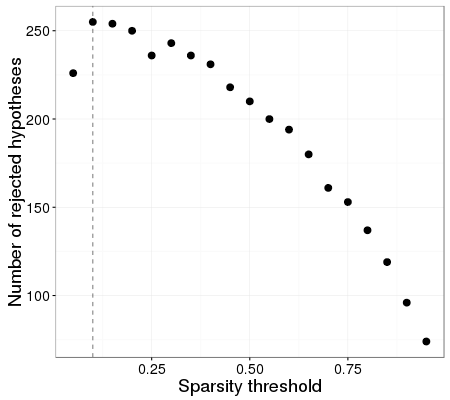

In [18]:
%%R -w 450 -h 400

ggplot(df.l2fc.rejH.s, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(size=3) +
    geom_vline(xintercept=max.rejH, linetype='dashed', alpha=0.5) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        )

In [19]:
%%R
df.l2fc.f = df.l2fc %>%
    filter(sparsity_threshold == 0.25) 

df.l2fc.f %>% nrow

[1] 3964


In [20]:
%%R
re = filter(df.l2fc.f, padj2 <=0.10)
length(re$OTU)

[1] 236


In [21]:
%%R #-i workDir
# Writing out l2fc table

outFile = 'data/l2fc_sparse-maxRejH_bulk_OM.txt'
write.table(df.l2fc.f, 'data/l2fc_sparse-maxRejH_bulk_OM.txt', sep='\t', quote=FALSE, row.names=FALSE)

In [4]:
%%R
df.l2fc = read.table('data/l2fc_sparse-maxRejH_bulk_OM.txt', sep='\t', header = TRUE)

In [5]:
%%R
df.l2fc$Rank2 = gsub("__", "", df.l2fc$Rank2)
df.l2fc$Rank3 = gsub("__", "", df.l2fc$Rank3)
df.l2fc$Rank4 = gsub("__", "", df.l2fc$Rank4)
df.l2fc$Rank5 = gsub("__", "", df.l2fc$Rank5)
df.l2fc$Rank6 = gsub("__", "", df.l2fc$Rank6)
df.l2fc$Rank7 = gsub("__", "", df.l2fc$Rank7)

In [6]:
%%R
print(length(df.l2fc$OTU))
print(length(unique(df.l2fc$OTU)))

[1] 3964
[1] 3964


In [7]:
%%R
resp = df.l2fc %>% filter(padj2 <=0.10) %>% group_by(OM) %>% summarise(resp = n())
resp %>% as.data.frame

         OM resp
1 Harvested  137
2  Returned   99


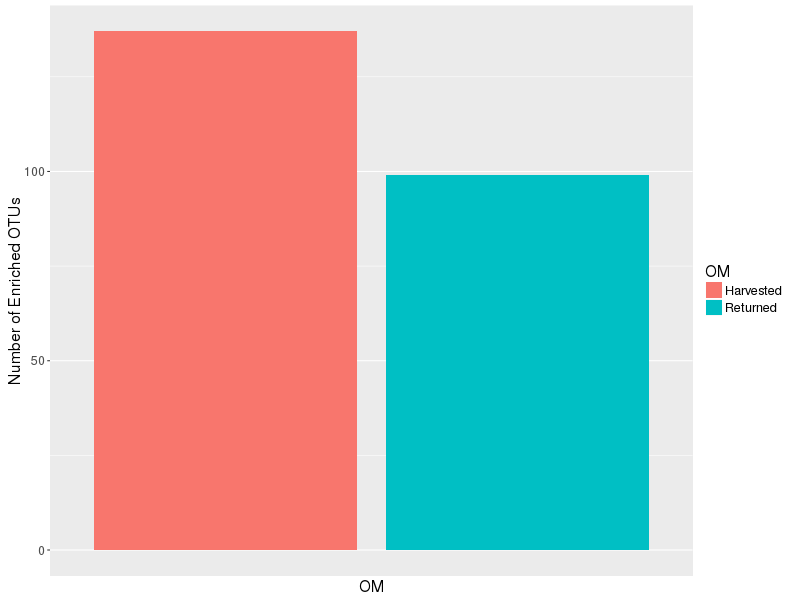

In [8]:
%%R -w 800 -h 600
p = ggplot(data = resp, aes(x = OM, y = resp, fill = OM)) +
    geom_bar(stat = 'identity') + 
    theme(text = element_text(size=16)) + ylab("Number of Enriched OTUs") + scale_x_discrete(breaks=NULL)
p

In [9]:
%%R
ggsave(filename = "data/figs/EnrichedNumoverTime.jpg", plot = p, width =12, height =6)

####Function arguments

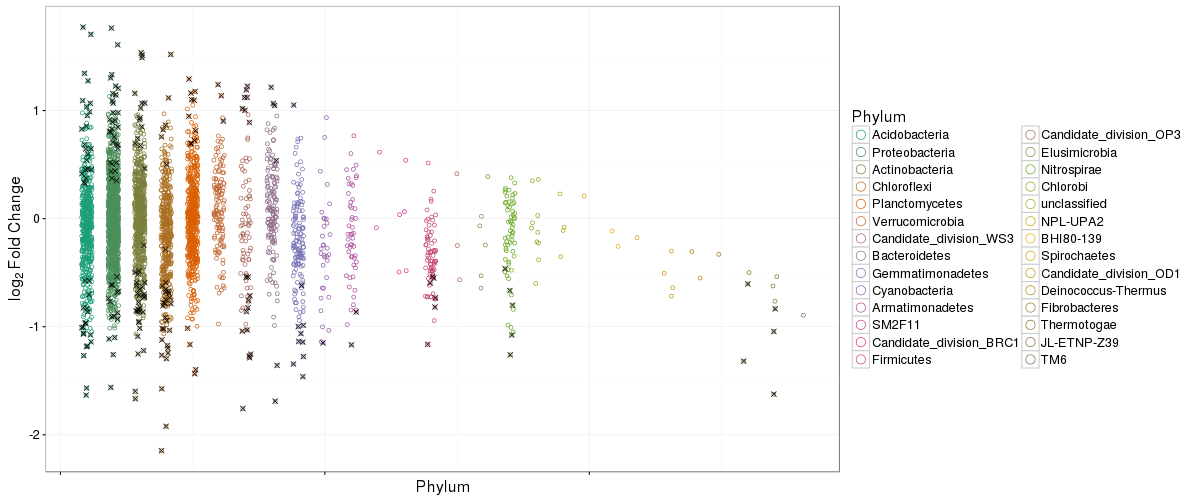

In [10]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj2 <= 0.10), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) #+ guides(color = FALSE)

p

In [11]:
%%R
colors.1 = c("#4B6586",
"#CFE335",
"#D14DE0",
"#68D842",
"#9C62D8",
"#8EAF36",
"#DA40B3",
"#5FE48B",
"#92388A",
"#C8E273",
"#6072D9",
"#DCB83E",
"#50468B",
"#E6882B",
"#6B94D2",
"#E54328",
"#65DBCC",
"#E33969",
"#60B571",
"#D24B8A",
"#44842C",
"#DE79C6",
"#A3E3AB",
"#B83130",
"#7EBDDB",
"#BF5B2A",
"#B58ADB",
"#9D7223",
"#D8B2D7",
"#30471E",
"#C8DCD5",
"#4C1D13",
"#D9D898",
"#33294C",
"#DA995E",
"#7A2D59",
"#6C7029",
"#926A93",
"#A49E5F",
"#431D2C",
"#DDB49B",
"#2D3F3D",
"#E27566",
"#599193",
"#82361D",
"#528566",
"#AA4455",
"#A39D98",
"#CBA899",
"#D78899",
"#4F3A18",
"#7B5E60",
"#91694B")

In [12]:
%%R
new_df.l2fc = df.l2fc
new_df.l2fc$Resp_status[new_df.l2fc$padj2 > 0.10] = "non-responder"
new_df.l2fc$Resp_status[new_df.l2fc$padj2 <= 0.10 & new_df.l2fc$log2FoldChange < 0] = 'Harvested'
new_df.l2fc$Resp_status[new_df.l2fc$padj2 <= 0.10 &  new_df.l2fc$log2FoldChange > 0] = "Returned"

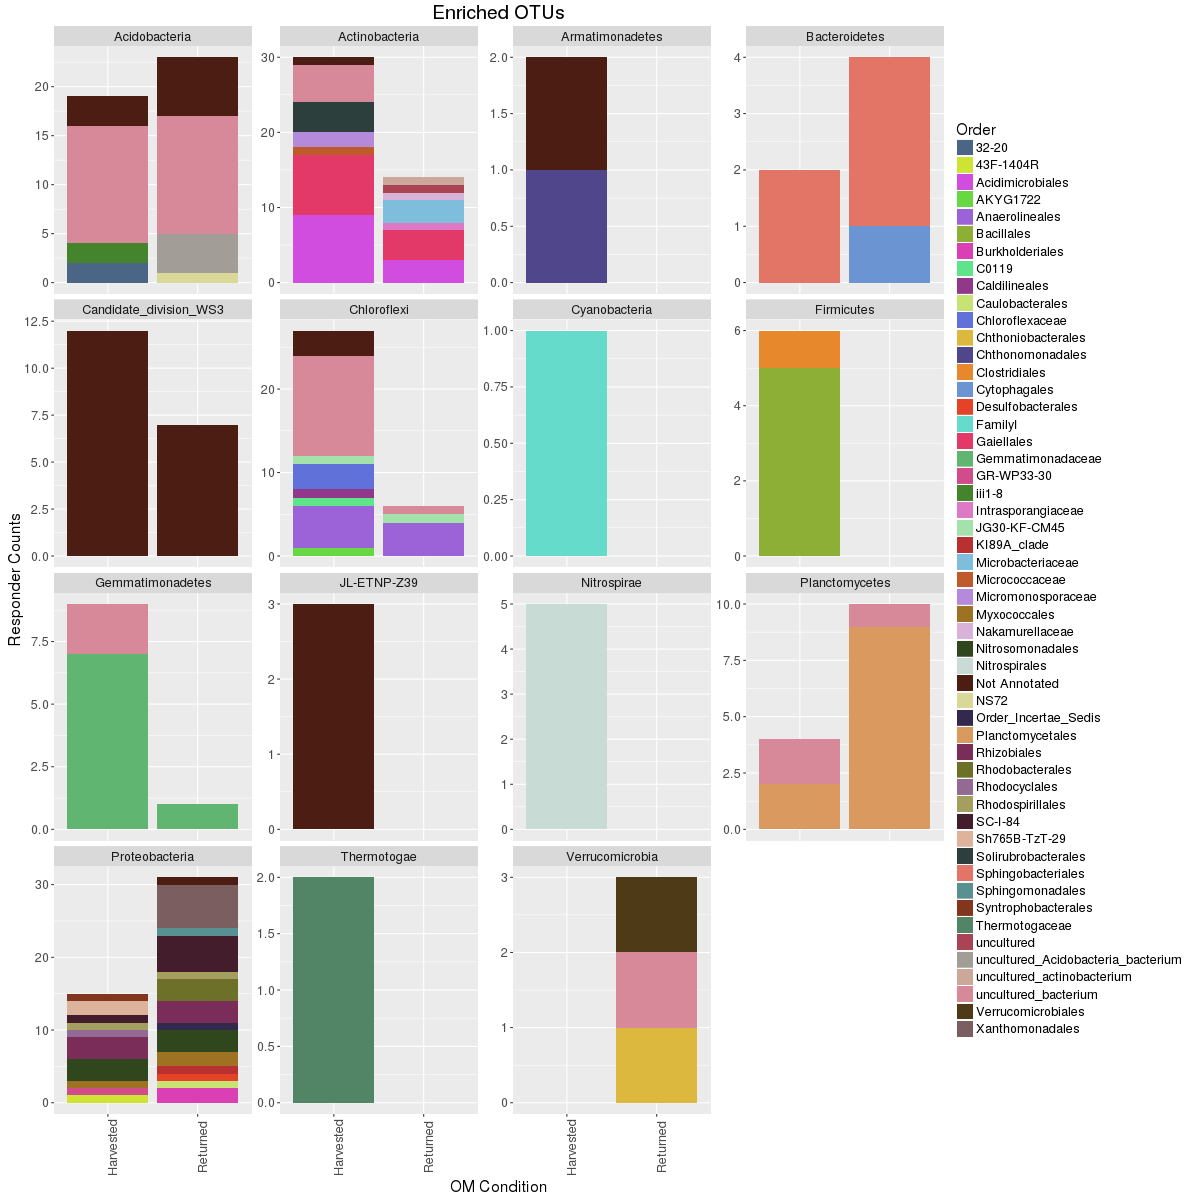

In [13]:
%%R -w 1200 -h 1200
dcounts = new_df.l2fc %>%
          #filter(!is.na(log2FoldChange)) %>%
          #filter(!is.na(padj)) %>%
          filter(Resp_status %in% c("Harvested", "Returned")) %>%
          group_by(Rank6, Rank5, Rank4, Rank3, Rank2, Resp_status) %>%
          summarize(responders = sum(padj2<= 0.10)) %>% ungroup() %>% arrange(Rank4)

dcounts$Rank4[is.na(dcounts$Rank4)] = "Not Annotated"
dcounts$Rank5[is.na(dcounts$Rank5)] = "Not Annotated"
#dcounts$Rank3 = reorder(dcounts$Rank3, -dcounts$responders)
#newrow = c("__Firmicutes", "October", "PT enriched", as.numeric(0))
#dcounts = rbind(dcounts,newrow)
#newrow = c("__Armatimonadetes", "October", "PT enriched", 0)
#dcounts = rbind(dcounts,newrow)
#newrow = c("__Armatimonadetes", "November", "PT enriched", 0)
#dcounts = rbind(dcounts,newrow)
#newrow = c("__Cyanobacteria", "November", "PT enriched", 0)
#dcounts = rbind(dcounts,newrow)
#dcounts$Rank3 <- droplevels(dcounts$Rank3)
#dcounts$responders= as.numeric(dcounts$responders)
#dcounts$Rank3 = reorder(dcounts$Rank3, -dcounts$responders)

p = ggplot(dcounts, aes(x = Resp_status , y = responders, fill = Rank4)) +
    geom_bar(stat = "identity") + #scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap(~Rank2, scales = "free_y") +
    #scale_y_discrete(limits = (0, 50)) +
    ggtitle("Enriched OTUs") + ylab("Responder Counts")+
    xlab("OM Condition") + guides(fill=guide_legend(title='Order', ncol = 1)) +
    theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) + 
    scale_fill_manual(values = colors.1) 

p

In [14]:
%%R
ggsave(filename = "data/figs/OMEnriched_byOrder.jpg", plot = p, width =14, height =14)

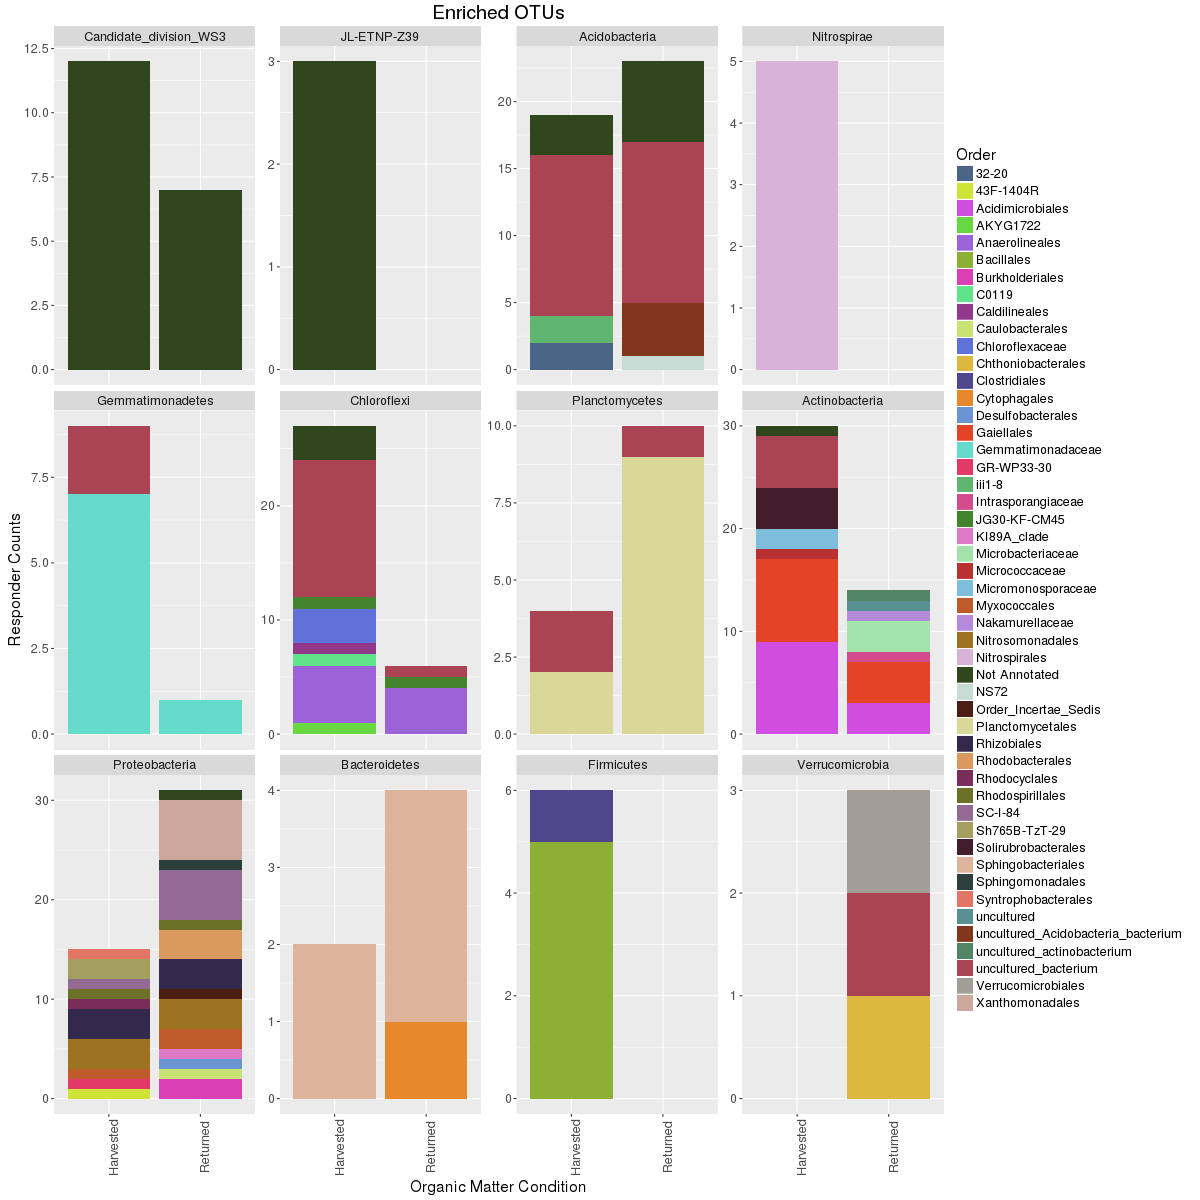

In [15]:
%%R -w 1200 -h 1200
Resp.to.keep = new_df.l2fc %>% group_by(Rank2, Resp_status) %>% summarise(Resp = sum(padj2<= 0.10)) %>% filter(Resp > 2)

dcounts.filt = filter(dcounts, Rank2 %in% Resp.to.keep$Rank2)

dcounts.filt$Rank3 = reorder(dcounts.filt$Rank3, -dcounts.filt$responders)
dcounts.filt$Rank2 = reorder(dcounts.filt$Rank2, -dcounts.filt$responders)


p = ggplot(dcounts.filt, aes(x = Resp_status , y = responders, fill = Rank4)) +
    geom_bar(stat = "identity") + #scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap(~Rank2, scales = "free_y") +
    #scale_y_discrete(limits = (0, 50)) +
    ggtitle("Enriched OTUs") + ylab("Responder Counts")+
   xlab("Organic Matter Condition") + guides(fill=guide_legend(title='Order', ncol = 1)) +
    theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) +#, legend.position=c(2, 0.2)) +
    scale_fill_manual(values = colors.1)



p

In [16]:
%%R
(Resp.to.keep)

Source: local data frame [18 x 3]
Groups: Rank2 [12]

                    Rank2 Resp_status  Resp
                    (chr)       (chr) (int)
1           Acidobacteria   Harvested    19
2           Acidobacteria    Returned    23
3          Actinobacteria   Harvested    30
4          Actinobacteria    Returned    14
5           Bacteroidetes    Returned     4
6  Candidate_division_WS3   Harvested    12
7  Candidate_division_WS3    Returned     7
8             Chloroflexi   Harvested    27
9             Chloroflexi    Returned     6
10             Firmicutes   Harvested     6
11       Gemmatimonadetes   Harvested     9
12            JL-ETNP-Z39   Harvested     3
13            Nitrospirae   Harvested     5
14         Planctomycetes   Harvested     4
15         Planctomycetes    Returned    10
16         Proteobacteria   Harvested    15
17         Proteobacteria    Returned    31
18        Verrucomicrobia    Returned     3


In [17]:
%%R
ggsave(filename = "data/figs/OMEnriched_byOrder_filt.jpg", plot = p, width =18, height =14)